In [1]:
import os

import tensorflow as tf
import umap
import umap.plot
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from dask.distributed import Client

from lib.glove.glove import GloVe

2023-06-01 18:12:41.620914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 18:12:41.775656: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-01 18:12:41.775675: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-01 18:12:42.556023: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
filepath_words = "/mnt/research-data/main/twitter/new/UMAP-tweets-all-new-20220117-wordlist.txt"
# Multilingual, ref https://github.com/stopwords-iso/stopwords-iso/blob/682bcc330e7ebca13e928349263560e3bae84830/stopwords-iso.json
filepath_stopwords = "/mnt/research-data/main/stopwords.txt"


In [3]:
with open(filepath_stopwords) as handle:
	stopwords = [ word.strip() for word in handle ]

In [4]:
words = []
with open(filepath_words) as handle:
	stopwords_skipped = 0
	for line in handle:
		row = line.split("\t", maxsplit=1)
		if row == "" or len(row) < 2:
			continue
		try:
			row[0] = int(row[0])
		except:
			continue
		row[1] = row[1].rstrip("\n")
		if row[1] in stopwords:
			continue
		words.append(row)


print(f"{len(words)} read, {stopwords_skipped} stopwords skipped")
	

1499544 read, 0 stopwords skipped


In [5]:
print(len(words))
words

1499544


[[1, '\ue04b'],
 [1, '\ue057'],
 [1, '\ue331'],
 [1, '\ue058'],
 [1, '\ue04b'],
 [1, '\ue41d'],
 [1, '한'],
 [1, '\ue402'],
 [1, '\ue331'],
 [1, '\ue41d'],
 [1, '\ue331'],
 [1, '\ue01b'],
 [1, '\ue895'],
 [1, '\ue415'],
 [1, '\ue059'],
 [1, '해'],
 [1, '\ue13c'],
 [1, '\ue04b'],
 [1, '\ue107'],
 [1, '\ue00e'],
 [1, '\ue331'],
 [1, '\ue00e'],
 [1, '\ue04a'],
 [1, '\ue402'],
 [1, '\ue058'],
 [1, '\ue058'],
 [1, '\ue41d'],
 [1, '\ue135'],
 [1, '더'],
 [1, '\uf62e'],
 [1, '\ue40d'],
 [1, '중'],
 [1, '🧊'],
 [1, '🧐'],
 [1, '🤮'],
 [1, '🥺'],
 [1, '🤮'],
 [1, '🤬'],
 [1, '🧸'],
 [1, '🧐'],
 [1, '🤭'],
 [1, '🪁'],
 [1, '🤩'],
 [1, '🤬'],
 [1, '🤍'],
 [1, '🥲'],
 [1, '🤬'],
 [1, '🦫'],
 [1, '🤟'],
 [1, '🥏'],
 [1, '🥺'],
 [1, '🤫'],
 [1, '🧳'],
 [1, '🥶'],
 [1, '🧨'],
 [1, '🧡'],
 [1, '🥺'],
 [1, '🧢'],
 [1, '🥰'],
 [1, '🥺'],
 [1, '🤲'],
 [1, '🥴'],
 [1, '🤭'],
 [1, '🥶'],
 [1, '🥳'],
 [1, '🥾'],
 [1, '🤪'],
 [1, '🤬'],
 [1, '🥺'],
 [1, '🧐'],
 [1, '🤭'],
 [1, '🤨'],
 [1, '🟥'],
 [1, '🟦'],
 [1, '🤪'],
 [1, '🟠'],
 [1, '🤨'],
 [1, '🤬'],
 [

In [6]:
glove = GloVe("/mnt/research-data/main/glove/glove.twitter.27B.25d.txt")


words_glove = [ glove.lookup(row[1]) for row in words ]
words_glove = list(filter(lambda vector: vector is not None, words_glove))

len(words_glove)


Loading GloVe from '/mnt/research-data/main/glove/glove.twitter.27B.25d.txt': 1190000... done in 9.417s.


70412

In [7]:
dimreducer = umap.UMAP(
	# min_dist=0.05
).fit(np.array(words_glove))

/home/bryan-smithl/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


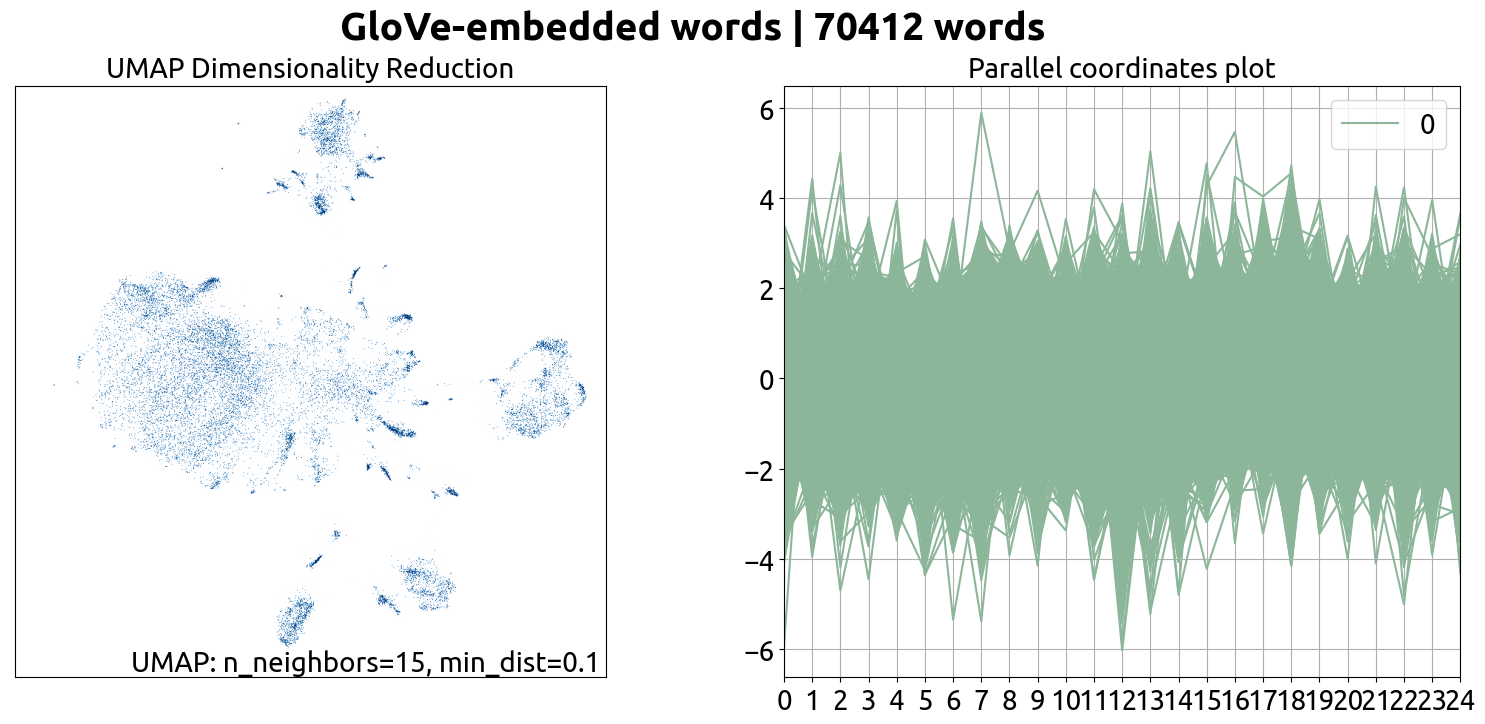

In [8]:
px = 1/plt.rcParams['figure.dpi'] # matplotlib sizes are in inches :-( :-( :-(
width = 1920
height = 768

plt.rc("font", size=20)
plt.rc("font", family="Ubuntu")
figure = plt.figure(figsize=(width*px, height*px))
figure.add_subplot(1, 2, 1)

# 1: UMAP
umap.plot.points(dimreducer,
    color_key_cmap="brg", # color_key_cmap="jet",
    ax=figure.get_axes()[0]
)
plt.title(f"UMAP Dimensionality Reduction", fontsize=20)

# 2: Parallel coordinates
figure.add_subplot(1, 2, 2)

dataframe = pd.DataFrame(np.array(words_glove))
dataframe["Label"] = 0
pd.plotting.parallel_coordinates(
    dataframe,
	class_column="Label",
    ax=figure.get_axes()[1],
    use_columns=False,
    axvlines=False
)

plt.title(f"Parallel coordinates plot", fontsize=20)
plt.suptitle(f"GloVe-embedded words | {len(words_glove)} words", fontsize=28, weight="bold")

plt.show()